# 1. Imports

In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np

# 2. Data 

## 2.1 Loaders

### 2.1.1 MNIST Data

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
    ])
batch_size = 64

datasets_save_dir = 'Data/'

train_data = datasets.MNIST(root=datasets_save_dir,download=True,train=True, 
    transform=transform)
test_data = datasets.MNIST(root=datasets_save_dir,download=True,train=False, 
    transform=transform)

train_dataloader = DataLoader(train_data,batch_size=batch_size,
    shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=True)

### 2.1.2 Subsets

In [3]:
subset_sizes = [1000*i for i in range(1,6)] 

subset_loaders = []
for subset_size in subset_sizes:
    subset, _ = random_split(train_data, [subset_size, len(train_data) - subset_size])
    subset_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    subset_loaders.append(subset_loader)

## 2.2 Data shape

In [4]:
for images, labels in train_dataloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


# 3. Model

In [5]:
class Fcnn(nn.Module):
    def __init__(self):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.Softmax()
        )

    def forward(self,x):
        x = self.block_1(x)
        return x
    

    def weights_normal(self,mean,std):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=mean, std=std) 
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def weights_ones(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.ones_(m.weight) 
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

In [6]:
model_1 = Fcnn()

# 4. Training

In [7]:
def train(epochs:int,model,optimizer,criterion,data):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        batch_loss = []
        for batch, (images,labels) in enumerate(data):
            images = images.view(images.shape[0],-1)

            optimizer.zero_grad()
            
            output = model(images)

            loss = criterion(output,labels) 
            loss.backward()

            optimizer.step()
            
            batch_loss.append(loss.item())
            if (batch+1) % 100 == 0:
                print(f'epoch: {epoch+1}, step: {batch+1}/{len(data)}, loss: {loss.item():.4f}')
        avg_batch_loss = sum(batch_loss)/len(batch_loss)
        loss_history.append(avg_batch_loss)
            
    print('Finished training!')
    return loss_history

In [8]:
epochs = 8
optimizer = torch.optim.Adam(model_1.parameters())
criterion = nn.CrossEntropyLoss()

loss_history_1 = train(epochs, model_1, optimizer, criterion, train_dataloader)

c:\Users\Komputer\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch: 1, step: 100/938, loss: 1.7672
epoch: 1, step: 200/938, loss: 1.6182
epoch: 1, step: 300/938, loss: 1.6687
epoch: 1, step: 400/938, loss: 1.6785
epoch: 1, step: 500/938, loss: 1.5977
epoch: 1, step: 600/938, loss: 1.5140
epoch: 1, step: 700/938, loss: 1.5895
epoch: 1, step: 800/938, loss: 1.6030
epoch: 1, step: 900/938, loss: 1.5674
epoch: 2, step: 100/938, loss: 1.5486
epoch: 2, step: 200/938, loss: 1.5634
epoch: 2, step: 300/938, loss: 1.5710
epoch: 2, step: 400/938, loss: 1.5115
epoch: 2, step: 500/938, loss: 1.4981
epoch: 2, step: 600/938, loss: 1.5262
epoch: 2, step: 700/938, loss: 1.5431
epoch: 2, step: 800/938, loss: 1.5138
epoch: 2, step: 900/938, loss: 1.5254
epoch: 3, step: 100/938, loss: 1.5501
epoch: 3, step: 200/938, loss: 1.4907
epoch: 3, step: 300/938, loss: 1.5972
epoch: 3, step: 400/938, loss: 1.5490
epoch: 3, step: 500/938, loss: 1.5001
epoch: 3, step: 600/938, loss: 1.5456
epoch: 3, step: 700/938, loss: 1.5234
epoch: 3, step: 800/938, loss: 1.5275
epoch: 3, st

# 5. Testing

In [9]:
def test(model, data):
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch, (images,labels) in enumerate(data):
            images = images.view(images.shape[0],-1)

            output = model(images)
            pred = output.data.max(1,keepdim=True)[1]
            
            labels = labels.data.view_as(pred)
            correct += pred.eq(labels).sum()
    accuracy = correct/len(data.dataset)
    print(f'Accuracy: {accuracy:.3f}')
    return accuracy


In [10]:
accuracy_1 = test(model_1, test_dataloader)

Accuracy: 0.962


# 6. Weight initialization

## 6.1 Large weights

In [11]:
model_2 = Fcnn()
optimizer = torch.optim.Adam(model_2.parameters())
model_2.weights_normal(mean=1000, std=20)

loss_history_2 = train(epochs, model_2, optimizer, criterion, train_dataloader)

epoch: 1, step: 100/938, loss: 2.3020
epoch: 1, step: 200/938, loss: 2.3029
epoch: 1, step: 300/938, loss: 2.3022
epoch: 1, step: 400/938, loss: 2.3023
epoch: 1, step: 500/938, loss: 2.3002
epoch: 1, step: 600/938, loss: 2.3043
epoch: 1, step: 700/938, loss: 2.2999
epoch: 1, step: 800/938, loss: 2.3017
epoch: 1, step: 900/938, loss: 2.3012
epoch: 2, step: 100/938, loss: 2.2986
epoch: 2, step: 200/938, loss: 2.3012
epoch: 2, step: 300/938, loss: 2.3000
epoch: 2, step: 400/938, loss: 2.3011
epoch: 2, step: 500/938, loss: 2.3011
epoch: 2, step: 600/938, loss: 2.3045
epoch: 2, step: 700/938, loss: 2.2986
epoch: 2, step: 800/938, loss: 2.3023
epoch: 2, step: 900/938, loss: 2.3091
epoch: 3, step: 100/938, loss: 2.3039
epoch: 3, step: 200/938, loss: 2.3018
epoch: 3, step: 300/938, loss: 2.3021
epoch: 3, step: 400/938, loss: 2.3054
epoch: 3, step: 500/938, loss: 2.2996
epoch: 3, step: 600/938, loss: 2.3025
epoch: 3, step: 700/938, loss: 2.3042
epoch: 3, step: 800/938, loss: 2.2951
epoch: 3, st

In [12]:
accuracy_2 = test(model_2, test_dataloader)

Accuracy: 0.113


## 6.2 All weights set to 1

In [13]:
model_3 = Fcnn()
optimizer = torch.optim.Adam(model_3.parameters())
model_3.weights_ones()

loss_history_3 = train(epochs, model_3, optimizer, criterion, train_dataloader)

epoch: 1, step: 100/938, loss: 2.3023
epoch: 1, step: 200/938, loss: 2.3026
epoch: 1, step: 300/938, loss: 2.3027
epoch: 1, step: 400/938, loss: 2.3024
epoch: 1, step: 500/938, loss: 2.3020
epoch: 1, step: 600/938, loss: 2.3036
epoch: 1, step: 700/938, loss: 2.3026
epoch: 1, step: 800/938, loss: 2.3029
epoch: 1, step: 900/938, loss: 2.2994
epoch: 2, step: 100/938, loss: 2.3012
epoch: 2, step: 200/938, loss: 2.2999
epoch: 2, step: 300/938, loss: 2.3025
epoch: 2, step: 400/938, loss: 2.3027
epoch: 2, step: 500/938, loss: 2.3013
epoch: 2, step: 600/938, loss: 2.3009
epoch: 2, step: 700/938, loss: 2.3034
epoch: 2, step: 800/938, loss: 2.3012
epoch: 2, step: 900/938, loss: 2.3041
epoch: 3, step: 100/938, loss: 2.2992
epoch: 3, step: 200/938, loss: 2.3034
epoch: 3, step: 300/938, loss: 2.2975
epoch: 3, step: 400/938, loss: 2.3069
epoch: 3, step: 500/938, loss: 2.2976
epoch: 3, step: 600/938, loss: 2.3059
epoch: 3, step: 700/938, loss: 2.3036
epoch: 3, step: 800/938, loss: 2.2978
epoch: 3, st

In [14]:
accuracy_3 = test(model_3, test_dataloader)

Accuracy: 0.113


## 6.3 Results

C:\Users\Komputer\AppData\Local\Temp\ipykernel_11236\306140487.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


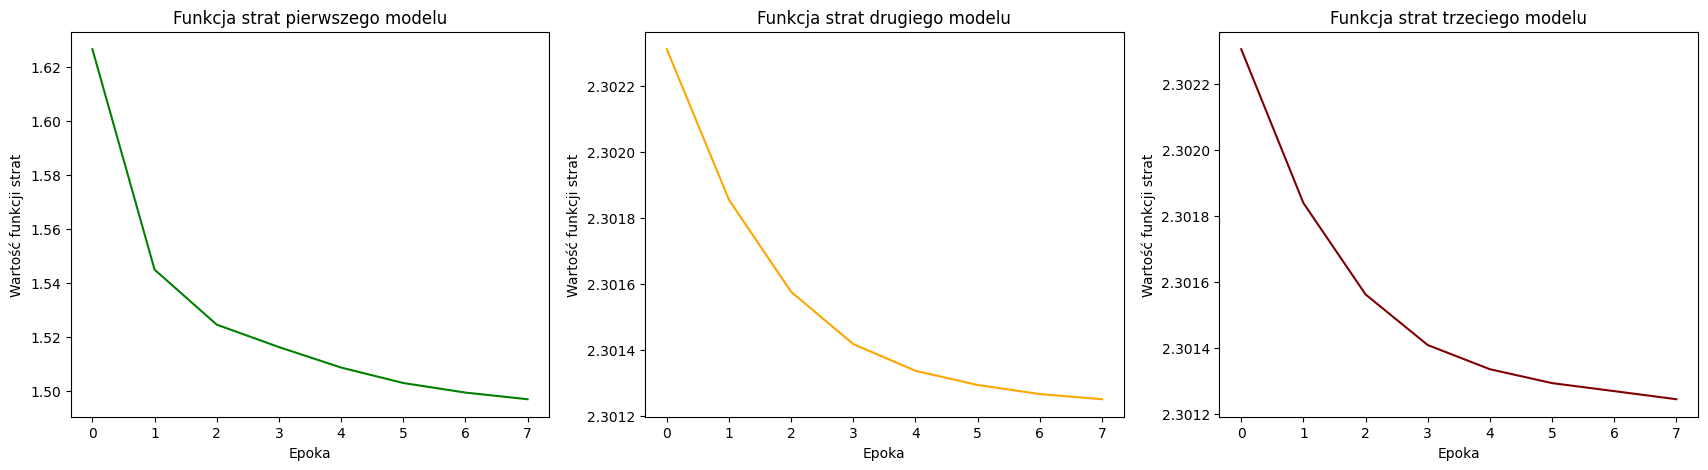

In [40]:
plt.subplots(figsize=(21, 5))

plt.subplot(1, 3, 1)
plt.plot(loss_history_1, color='green')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat pierwszego modelu')

plt.subplot(1, 3, 2)
plt.plot(loss_history_2, color='orange')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat drugiego modelu')

plt.subplot(1, 3, 3)
plt.plot(loss_history_3, color='maroon')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat trzeciego modelu')

plt.show()

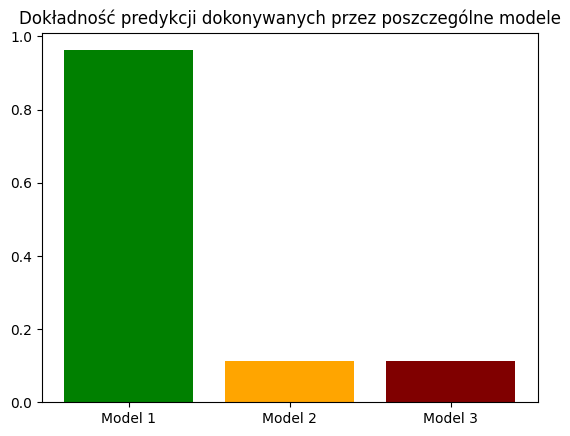

In [26]:
plt.bar(['Model 1', 'Model 2', 'Model 3'], [accuracy_1, accuracy_2, accuracy_3], color=['green', 'orange', 'maroon'])
plt.title('Dokładność predykcji dokonywanych przez poszczególne modele')

plt.show()

Domyślne wagi zaimplementowane przez PyTorch (użyte w pierwszym modelu), czyli bardzo bliskie 0, działają najlepiej. Wyniki uzyskiwane przez model można wówczas uznać za satysfakcjonujące. Inicjalizacja innych wag sprawia, że wyniki predykcji modelu są bardzo dalekie od oczekiwań. Dotyczy to zarówno poprawności predykcji jak i funkcji strat.

# 7. Training on subsets of different sizes

In [27]:
subset_loss_history = []
subset_accuracy_train = []
subset_accuracy_test = []

for subset in subset_loaders:
    subset_model = Fcnn()
    optimizer = torch.optim.Adam(subset_model.parameters())
    loss_history = train(3,subset_model,optimizer,criterion,subset)
    subset_loss_history.append(loss_history)

    accuracy_test = test(subset_model,test_dataloader)
    accuracy_train = test(subset_model,train_dataloader)
    
    subset_accuracy_train.append(accuracy_train)
    subset_accuracy_test.append(accuracy_test)

c:\Users\Komputer\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Finished training!
Accuracy: 0.627
Accuracy: 0.624
Finished training!
Accuracy: 0.811
Accuracy: 0.800
Finished training!
Accuracy: 0.786
Accuracy: 0.779
Finished training!
Accuracy: 0.845
Accuracy: 0.839
Finished training!
Accuracy: 0.832
Accuracy: 0.824


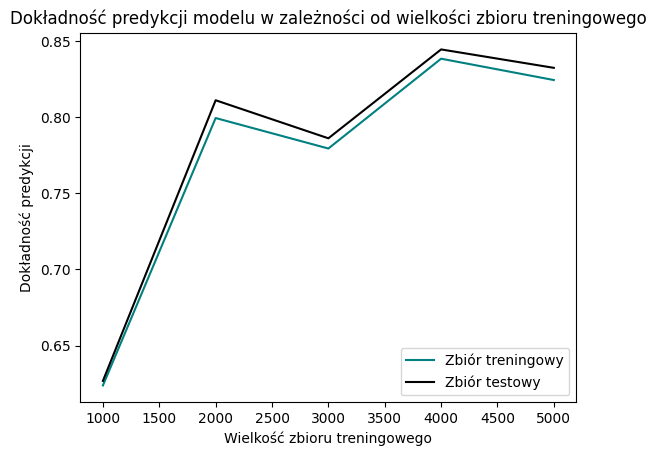

In [70]:
plt.plot(subset_sizes, subset_accuracy_train, label='Zbiór treningowy', color='teal')
plt.plot(subset_sizes, subset_accuracy_test, label='Zbiór testowy', color='black')

plt.xlabel('Wielkość zbioru treningowego')
plt.ylabel('Dokładność predykcji')
plt.title('Dokładność predykcji modelu w zależności od wielkości zbioru treningowego')

plt.legend(loc='lower right')

Na powyższym wykresie możemy zauważyć trend wzrostowy w zależności pomiędzy zwiększaniem zbioru treningowego a dokładnością predykcji modelu.

# 8. Early stopping

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
def train_es(epochs:int,model,optimizer,criterion,dataloader):
    early_stopper = EarlyStopper(patience=2, min_delta=10)
    model.train()
    for epoch in range(epochs):
        batch_loss_history = []
        for batch, (images,labels) in enumerate(dataloader):
            images = images.view(images.shape[0],-1)

            optimizer.zero_grad()
            
            output = model(images)

            loss = criterion(output,labels)
            loss.backward()

            optimizer.step()
            if (batch+1) % 100 == 0:
                print(f'epoch: {epoch+1}, step: {batch+1}/{len(dataloader)} , loss: {loss.item():.4f}')
            batch_loss_history.append(loss.item())
        
        print(torch.float)
        epoch_avg_loss = np.average(batch_loss_history)
        if early_stopper.early_stop(epoch_avg_loss):
            print('Early stopping!')
            break
        
        print(f'Epoch: {epoch+1}, avg_loss = {epoch_avg_loss}')
    print('Finished training!')



In [ ]:
epochs = 20
model_4 = Fcnn()
optimizer = torch.optim.Adam(model_4.parameters())

train_es(epochs, model_4, optimizer, criterion, dataloader=subset_loaders[0])

# 9. Dropout